In [1]:
!pip install -e ../../.
from climpyrical.mask import *
from climpyrical.gridding import *
from climpyrical.datacube import *

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd

from sklearn import ensemble
import seaborn as sns
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from sklearn.metrics import *
from sklearn.neighbors import KNeighborsRegressor
from scipy import stats

from sklearn.metrics.pairwise import paired_distances
from scipy.spatial import distance
from scipy.stats import linregress

import plotly.graph_objects as go
import plotly
from plotly.subplots import make_subplots
import chart_studio.plotly as py
from plotly import colors as clr
import chart_studio
import xgeo

chart_studio.tools.set_config_file(world_readable=False,
                             sharing='private')

%load_ext autoreload
%autoreload 2

Obtaining file:///home/nannau/temp/climpyrical/climpyrical_master/climpyrical
  Found existing installation: climpyrical 0.1.dev0
    Uninstalling climpyrical-0.1.dev0:
      Successfully uninstalled climpyrical-0.1.dev0
  Running setup.py develop for climpyrical
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
PATH = '../../climpyrical/tests/data/snw_test_ensemble.nc'
dv = 'Rain-RL50'
dsold = read_data(PATH, dv)

NNN = 3
ds = regrid_ensemble(dsold, dv, NNN)


In [3]:
shape = ds[dv].values[0, ...].shape

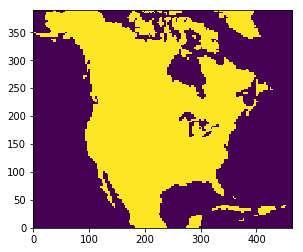

In [4]:
mask = read_data('/home/nannau/temp/climpyrical/climpyrical_master/climpyrical/climpyrical/tests/data/land_mask_CanRCM4_sftlf.nc', design_value_name='sftlf', keys={'rlat', 
'rlon'})
dvmask = 'sftlf'
# mask
mask = regrid_ensemble(mask, 'sftlf', NNN, keys={'rlat', 'rlon'})
mask = mask[dvmask].values >= 1.0
plt.imshow(mask, origin='lower')

In [5]:
ens_mean = np.mean(ds[dv].values, axis=0)
ens_mean.shape

(390, 465)

In [6]:
# Create a mask of extra NaN values that is flattened
flat_mask_with_extra_nan = np.logical_and(~np.isnan(ens_mean.flatten()), mask.flatten())

# Put back into the spatial shape
final_mask = flat_mask_with_extra_nan.reshape(ens_mean.shape)

# create two grids of rlon and rlat to use new mask with
rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)

# check that the shapes of all of the arrays after masking are consistent
assert rlat[final_mask].shape == rlon[final_mask].shape and ens_mean[final_mask].shape == rlat[final_mask].shape

In [15]:
df = pd.read_csv('../../climpyrical/tests/data/stations.csv', index_col=None)
station_dv = 'RL50 (kPa)'

# transform into rotated pole
rlon_st, rlat_st = transform_coords(df['lon'].values, df['lat'].values)
df = df.assign(
        rlon=rlon_st, 
        rlat=rlat_st
)
df = df[df[station_dv] != 0.0]

# Add nearest rlon and rlat locations in grid to stations
rlon_nearest_index, rlat_nearest_index = find_element_wise_nearest_pos(ds.rlon.values, ds.rlat.values, df.rlon.values, df.rlat.values)

# df = df.assign(
#         rlon=rlon[rlat_nearest_index, rlon_nearest_index], 
#         rlat=rlat[rlat_nearest_index, rlon_nearest_index]
# )

df = df.assign(
    label='stations',
    rlon_nearest_index = rlon_nearest_index, 
    rlat_nearest_index = rlat_nearest_index,
    nearest_grid = list(zip(rlon_nearest_index, rlat_nearest_index))
)

# Group together stations falling in same grid cell and take mean
ndf = df.groupby(['nearest_grid'], as_index=False).agg({
                                station_dv: 'mean',
                                'lat':'mean',
                                'lon':'mean',
                                'rlat': 'mean',
                                'rlon': 'mean',
                                'rlon_nearest_index':'mean',
                                'rlat_nearest_index':'mean',
                                'label': 'min',
                            })

# Get the indices for each grid axis that are matched and grouped
rlon_i_agg, rlat_i_agg = ndf.rlon_nearest_index.values, ndf.rlat_nearest_index.values

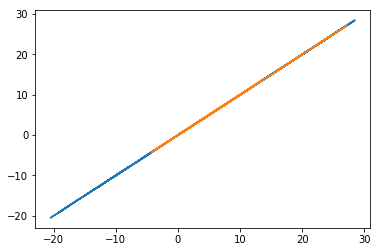

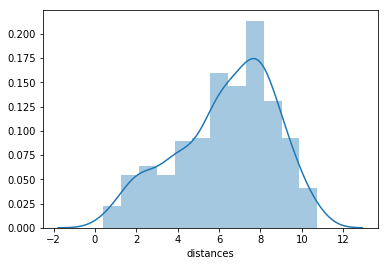

In [134]:
plt.plot(rlon[rlat_nearest_index, rlon_nearest_index], df.rlon.values)
plt.plot(rlat[rlat_nearest_index, rlon_nearest_index], df.rlat.values)
plt.show()

from sklearn.metrics import pairwise_distances_argmin_min

distance_to_nearest_gridcell = pairwise_distances_argmin_min( 
    np.deg2rad(np.stack([ndf.rlon, ndf.rlat]).T), 
    np.deg2rad(
        np.stack([rlon[rlat_i_agg, rlon_i_agg], rlat[rlat_i_agg, rlon_i_agg]]).T
    ),
    metric='haversine'
    
)[1]*6371000/1000
ndf['distances']=distance_to_nearest_gridcell
sns.distplot(ndf['distances'])

In [135]:
X = np.stack([df.rlon.values, df.rlat.values]).T

# rlat_nearest_index, rlon_nearest_index

X = np.stack(
        [
            rlon[rlat_nearest_index, rlon_nearest_index], 
            rlat[rlat_nearest_index, rlon_nearest_index]
        ]
).T

Xf = np.stack(
        [
            rlon[final_mask], 
            rlat[final_mask]
        ]
).T

model_arr = np.array([
                        find_nearest_index_value(
                            ds.rlon.values, 
                            ds.rlat.values, 
                            rlon_nearest_index, 
                            rlat_nearest_index, 
                            ds[dv].values[i, ...], 
                            final_mask, 
                            ds
                        ) for i in range(35)])
ratio = df[station_dv].values/model_arr
ratio[0,...].shape, X.shape

((378,), (378, 2))

In [136]:
KNeighborsRegressor()

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [144]:
warnings.filterwarnings('ignore')
predlist = []
predfull = []
params_fit = []
for i in range(35):
    print(i)
    parameters = {'n_neighbors': range(2, 50)}
    model = KNeighborsRegressor(weights='distance')
    clf = GridSearchCV(model, parameters, cv=10)
    clf.fit(X, ratio[i, ...])
    predlist.append(clf.predict(X))
    predfull.append(clf.predict(Xf))
    params_fit.append(clf.best_params_)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


In [138]:
preds = np.array(predlist)
preds = preds*model_arr
predsfull = np.array(predfull)*ds[dv].values[:, final_mask]

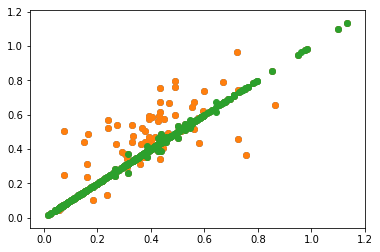

In [143]:
S = ds[dv].values.copy()
S[:, final_mask] = predsfull
# S[:, rlat_nearest_index, rlon_nearest_index] = preds

plt.scatter(find_nearest_index_value(
    ds.rlon.values, 
    ds.rlat.values, 
    rlon_nearest_index, 
    rlat_nearest_index, 
    S[0, ...].copy(), 
    final_mask, 
    ds
), df[station_dv])
plt.scatter(S[0, rlat_nearest_index, rlon_nearest_index], df[station_dv])
plt.scatter(preds[0, ...], df[station_dv])

In [111]:
assert np.all([np.isclose(mean_squared_error(preds[i, ...], df[station_dv]), 0.) for i in range(35)])


In [119]:
ks = np.array([t['n_neighbors'] for t in params_fit])
int(np.mean(ks))

21

In [120]:

model = KNeighborsRegressor(n_neighbors=9, weights='distance')
model.fit(X, ratio[0, ...])

def pwhole_(alpha, k, Y):
    rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)
    d_gridx = np.dstack((rlon, rlat))
    a = np.array([rlon[final_mask], rlat[final_mask]]).T
    a1 = np.array([df['rlon'].values, df['rlat'].values]).T
#     a1 = np.array([rlon[rlat_i_agg, rlon_i_agg], rlat[rlat_i_agg, rlon_i_agg]]).T
    model = KNeighborsRegressor(n_neighbors=k, weights='distance')
    model.fit(X, Y)
    d = model.kneighbors_graph(a, mode='distance').toarray()
    fracs = np.linspace(0.2, -5)
    residual = []
    residual_plain = []
    residual_inv=[]
    psumar=[]

    denom = np.exp(-alpha*np.sum(np.sort(d, axis=1)[:, :1], axis=1))
    num = np.exp(-alpha*np.sort(distance.cdist(a, a1), axis=1)[:, 0])

    p = num/denom
    pwhole = ens_mean.copy()
    pwhole[final_mask] = p
    pwhole[~final_mask] = np.nan
    return pwhole.reshape(ens_mean.shape)

In [ ]:
stations, mean = [], []
fracs = np.linspace(-1, 5, 30)

for frac in fracs:
    pwhole = pwhole_(frac, )
    
    values = np.stack([ndf.rlon, ndf.rlat])
    ndf['ratio'] = ndf[station_dv]/ndf.mean_values
    
    final = ens_mean.copy()
    Xfull = np.stack([rlon[final_mask], rlat[final_mask]])
    predfull = model.predict(Xfull.T)
    final[final_mask] = predfull
    final = ((np.ones(ens_mean.shape)-pwhole) + pwhole*final)*ens_mean

    final[~final_mask] = np.nan


    pred = find_nearest_index_value(ds.rlon.values, ds.rlat.values, rlon_i_agg, rlat_i_agg, final.copy(), final_mask, ds)
    station_vals = ndf['ratio'].values*ndf.mean_values
    stations.append(np.sqrt(mean_squared_error(station_vals, pred))) 